### keras RNN으로 여행자 수 예측

1. 패키지 수입 및 파라미터 설정

In [ ]:
# 패키지 수입
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from time import time
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.layers import Dense
from keras.layers import LSTM, InputLayer
from keras.models import Sequential
from sklearn.model_selection import train_test_split

In [ ]:
# 파라미터 설정
MY_PAST = 12
MY_SPLIT = 0.8
MY_HIDDEN = 300
MY_SHAPE = (MY_PAST, 1)
MY_EPOCH = 300

2. 데이터 처리

In [ ]:
# 데이터 읽기
raw = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/airline.csv',
                  header = None,  # 칼럼 이름들 <= csv에 칼럼 이름이 없으므로 넣어줘야한다
                  usecols = [1])

# 샘플 출력
print(raw.head(15))
print(raw.describe())

      1
0   112
1   118
2   132
3   129
4   121
5   135
6   148
7   148
8   136
9   119
10  104
11  118
12  115
13  126
14  141
                1
count  144.000000
mean   280.298611
std    119.966317
min    104.000000
25%    180.000000
50%    265.500000
75%    360.500000
max    622.000000


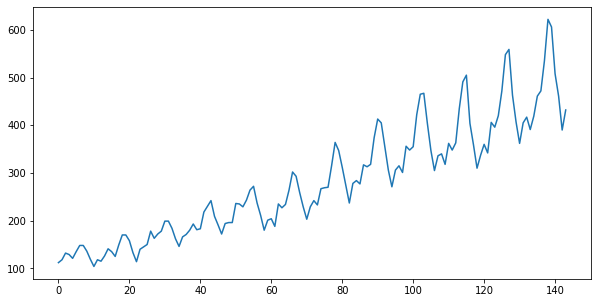

In [ ]:
plt.figure(figsize = (10,5))
plt.plot(raw)

<class 'numpy.ndarray'>
[0.01544402 0.02702703 0.05405405 0.04826255 0.03281853 0.05984556
 0.08494208 0.08494208 0.06177606 0.02895753 0.         0.02702703
 0.02123552 0.04247104 0.07142857 0.05984556 0.04054054 0.08687259
 0.12741313 0.12741313 0.1042471  0.05598456 0.01930502 0.06949807
 0.07915058 0.08880309 0.14285714 0.11389961 0.13127413 0.14285714
 0.18339768 0.18339768 0.15444015 0.11196911 0.08108108 0.11969112
 0.12934363 0.14671815 0.17181467 0.14864865 0.15250965 0.22007722
 0.24324324 0.26640927 0.2027027  0.16795367 0.13127413 0.17374517
 0.17760618 0.17760618 0.25482625 0.25289575 0.24131274 0.26833977
 0.30888031 0.32432432 0.25675676 0.20656371 0.14671815 0.18725869
 0.19305019 0.16216216 0.25289575 0.23745174 0.25096525 0.30888031
 0.38223938 0.36486486 0.2992278  0.24131274 0.19111969 0.24131274
 0.26640927 0.24903475 0.31467181 0.31853282 0.32046332 0.40733591
 0.5019305  0.46911197 0.4015444  0.32818533 0.25675676 0.33590734
 0.34749035 0.33397683 0.41119691 0.40

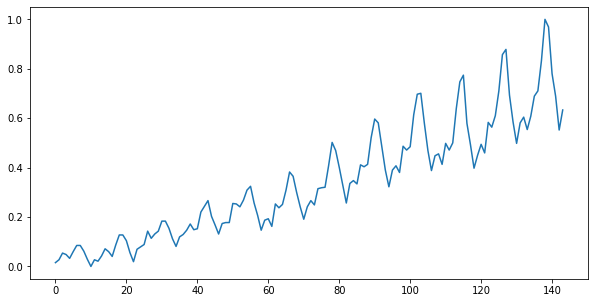

In [ ]:
# 데이터 정규화
scaler = MinMaxScaler()       # numpy로 만들어짐
#scaler = StandardScaler()      # z-정규화
s_data = scaler.fit_transform(raw)  #   <=> scaler.inverse_transform

print(type(s_data))
print(s_data.flatten())
plt.figure(figsize = (10,5))
plt.plot(s_data)

In [ ]:
# 데이터 분할
data = []

for i in range (len(s_data) - MY_PAST):
    data.append(s_data[i : i + MY_PAST + 1])
                    # [출발점 : 도착점 - 1]
print('한 묶음의 크기 :', len(data[0]))
print('총 묶음의 수 :', len(data))
print('첫번째 묶음 내용 \n', data[0])

한 묶음의 크기 : 13
총 묶음의 수 : 132
첫번째 묶음 내용 
 [[0.01544402]
 [0.02702703]
 [0.05405405]
 [0.04826255]
 [0.03281853]
 [0.05984556]
 [0.08494208]
 [0.08494208]
 [0.06177606]
 [0.02895753]
 [0.        ]
 [0.02702703]
 [0.02123552]]


In [ ]:
# 데이터를 numpy로 전환
print(type(data))
data = np.array(data)
print(type(data))

# 묶음들을 임의로 섞음
#np.random.shuffle(data)
print(data.shape)

# 데이터를 입력과 출력으로 분할
X_data = data[:, 0 : MY_PAST]   # 입력데이터 열 : 0 ~ 11(MY_PAST - 1)   [행 자르는 곳, 열 자르는 곳]
Y_data = data[:, -1]            # 출력데이터 열 : 12만  (MY_PAST)       [:,:] 행을 모두 취한다, 열을 모두 취한다.

print('입력 데이터 모양 :', X_data.shape)
print('출력 데이터 모양 :', Y_data.shape)

<class 'list'>
<class 'numpy.ndarray'>
(132, 13, 1)
입력 데이터 모양 : (132, 12, 1)
출력 데이터 모양 : (132, 1)


In [ ]:
# 데이터 4분할
X_train, X_test, Y_train, Y_test = train_test_split(X_data, 
                                                    Y_data, 
                                                    train_size = MY_SPLIT,
                                                    shuffle = False)

# 최종 데이터 모양 출력
print('학습용 입력데이터 모양 :', X_train.shape)
print('학습용 출력데이터 모양 :', Y_train.shape)
print('평가용 입력데이터 모양 :', X_test.shape)
print('평가용 출력데이터 모양 :', Y_test.shape)

학습용 입력데이터 모양 : (105, 12, 1)
학습용 출력데이터 모양 : (105, 1)
평가용 입력데이터 모양 : (27, 12, 1)
평가용 출력데이터 모양 : (27, 1)


3. 인공 신경망 구현

In [ ]:
# RNN 구현
model = Sequential()

model.add(InputLayer(input_shape = MY_SHAPE))

model.add(LSTM(units = MY_HIDDEN))

model.add(Dense(units = 1, activation = 'sigmoid'))
      # 지금까지 배운 활성화 함수 : relu(갯수를 정해주는 활성화 함수), softmax(확률을 만드는 활성화 함수)
      # sigmoid 활성화함수 : 딥러닝에서 가장 많이 쓰이는 함수
                           # 확률을 만드는 활성화 함수
                           # softmax는 여러 숫자를 확률로 만들고
                           # sigmoid는 하나의 숫자를 확률로 만든다.
print('RNN 요약')
model.summary()

RNN 요약
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 300)               362400    
_________________________________________________________________
dense (Dense)                (None, 1)                 301       
Total params: 362,701
Trainable params: 362,701
Non-trainable params: 0
_________________________________________________________________


4. 인공 신경망 학습

In [ ]:
# RNN 학습 설정
model.compile(optimizer = 'adam', loss = 'mape')
      # mae, rmse, mse : 숫자 맞추기
      # entropy : 구분하기
      # mape : Mean Absolute Percentage Error
      # mae :  Mean Absolute Error
      ## ex) 정답 : [1, 4, 2]  예측 : [1, 3, 5]
      ##     mae = (|1 - 1| + |4 - 3| + |2 - 5|) / 3 = 4/3
      ##    mape = (|(1 - 1) / 1| + |(4 - 3 ) / 4| + |(2 - 5 ) / 2|) / 3 * 100 = 54.17
      ### rmsprop : Root Mean Square Propagation
print('학습 시작')
begin = time()

model.fit(x = X_train, y = Y_train, epochs = MY_EPOCH, verbose = 0)

end = time()
print('학습시간 {:.2f}'.format(end-begin))

학습 시작
학습시간 7.23


5. 인공 신경망 평가

In [ ]:
# RNN 평가
score = model.evaluate(x = X_test, y = Y_test, verbose = 0)

print('최종 손실값 :', score)     # 숫자를 정확하게 맞추는건 정확도가 무의미 하기 때문에
                                  # 손실값만 보고 판단한다.
                                  # model.compile에서 metrics를 지우면 
                                  # score는 2차원배열에서 1차원 변수로 바뀐다.


최종 손실값 : 9.896550178527832


6. 인공 신경망 예측

스퀴즈 후
 [397 360 359 347 339 359 370 403 454 487 495 454 410 367 367 370 369 395
 401 433 474 509 518 487 447 415 415]
(27,)


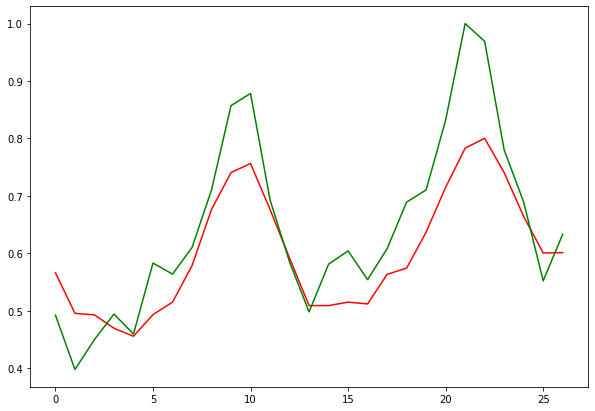

In [ ]:
# RNN으로 예측
pred = model.predict(x = X_test)

#print('역전환 전\n', pred)
#print(pred.shape)

# 예측 결과 및 정답 그래프 그리기
plt.figure(figsize = (10, 7))
plt.plot(pred, 'r')
plt.plot(Y_test, 'g')


# 데이터 역전환 (정규화 된 데이터 다시 되돌리기)
pred = scaler.inverse_transform(pred)

#print('역전환 후\n', pred)
#print(pred.shape)
tmp = np.squeeze(pred).astype(int)
                                   # squeeze : 2차원을 1차원으로 변형
                                   #  astype : 형태 변환
print('스퀴즈 후\n', tmp)
print(tmp.shape)

In [ ]:
# 정답 출력
#print('역전환 전 정답\n', Y_test)
tmp = scaler.inverse_transform(Y_test).astype(int)
tmp = np.squeeze(tmp)
print('역전환 후 정답\n', tmp)

역전환 후 정답
 [359 310 337 360 342 406 396 420 472 548 559 463 407 362 405 417 391 419
 461 472 535 622 606 508 461 390 432]


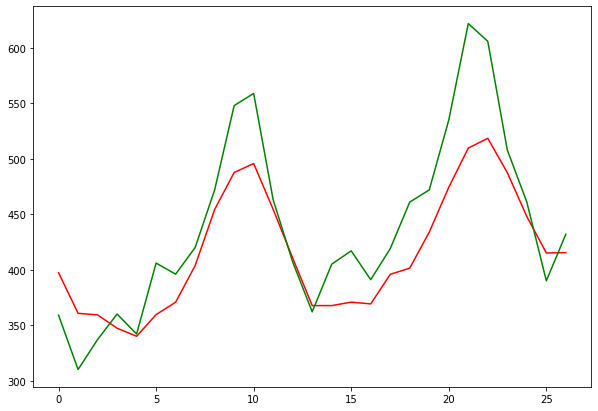

In [ ]:

# 예측 결과 및 정답 그래프 그리기
plt.figure(figsize = (10, 7))
plt.plot(pred, 'r')
plt.plot(tmp, 'g')

